In [1]:
import os
import time
from glob import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as im
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score, RocCurveDisplay, precision_recall_curve
from tqdm import tqdm
from scipy.special import expit

ROOT_FOLDER_PATH = "C:/Users/Zalamaan/Documents/Repos/NICU_Data/16bit_Depth_prePT/"
# allPts = [1, 2, 5, 6, 8, 9, 10, 11, 13, 14, 15, 16, 17, *range(21, 35), *range(90, 95)]
allPts = [1, 2, 5, 6, 8, 9, 10, 11, 13, 14, 15, 16, 17, *range(21, 35)]
# allPts = [1]

In [2]:
def testImshow(img):
    while True:
        cv2.imshow("test", img)

        # If user presses ESCAPE or clicks the close button, end    
        key = cv2.waitKey(1)
        if (key == 27) or (cv2.getWindowProperty("test", cv2.WND_PROP_VISIBLE) != 1):
            cv2.destroyAllWindows()
            break

def findUniqueFileNames(rootFolderPath, patientId):
    nurseFiles_path = rootFolderPath + 'p' + str(patientId) + '/nurse/*_0.png'
    nurseFiles = glob(nurseFiles_path)
    nooneFiles_path = rootFolderPath + 'p' + str(patientId) + '/noone/*_0.png'
    nooneFiles = glob(nooneFiles_path)

    uniqueFiles = list(set(nooneFiles).symmetric_difference(set(nurseFiles)))

    uniqueFileNames = []
    for file in uniqueFiles:
        uniqueFileNames.append(os.path.basename(file).split('.')[0][:-2])

    return uniqueFileNames

In [3]:
print('Started')
patientList = []
fileNames = []
baselineImgs = []
# allPts = [1]
for pt in allPts:
    uniqueFileNames = findUniqueFileNames(ROOT_FOLDER_PATH, pt)

    for fileName in uniqueFileNames:
        imgPath = ROOT_FOLDER_PATH + 'p' + str(pt) + '/noone/' + fileName + '*.png'
        imgPath = glob(imgPath)
        if imgPath == []:
            continue
        imgPath = imgPath[0]
        img = cv2.imread(imgPath, -1)
        baselineImg = img.astype(np.float32)
        patientList.append(pt)
        fileNames.append(fileName)
        baselineImgs.append(baselineImg)


Started


In [4]:
all_MSEs = []
all_y_true = []
for pt, fileName, baselineImg in zip(patientList, fileNames, baselineImgs):
        
    imgPaths_nurse = ROOT_FOLDER_PATH + 'p' + str(pt) + '/nurse/' + fileName + '*.png'
    imgPaths_noone = ROOT_FOLDER_PATH + 'p' + str(pt) + '/noone/' + fileName + '*.png'

    imgList_nurse = glob(imgPaths_nurse)
    imgList_noone = glob(imgPaths_noone)

    firstRun = True
    for i, imgPath in tqdm(enumerate(imgList_nurse)):
        img = cv2.imread(imgPath, -1)
        img = cv2.resize(img, (baselineImg.shape[1], baselineImg.shape[0]))
        if i == 0:
            nurseImgs = img.reshape((1, img.shape[0], img.shape[1]))
            firstRun = False
        else:
            nurseImgs = np.concatenate((nurseImgs, [img]))

    nurseMSEs = ((nurseImgs-baselineImg)**2).mean(axis=(1, 2))
    y_true = np.ones(nurseMSEs.shape[0])

    firstRun = True
    secondRun = True
    for i, imgPath in tqdm(enumerate(imgList_noone)):
        img = cv2.imread(imgPath, -1)
        img = cv2.resize(img, (baselineImg.shape[1], baselineImg.shape[0]))
        if i == 0:
            continue
        elif i == 1:
            nooneImgs = img.reshape((1, img.shape[0], img.shape[1]))
            firstRun = False
        else:
            nooneImgs = np.concatenate((nooneImgs, [img]))

    nooneMSEs = ((nooneImgs-baselineImg)**2).mean(axis=(1, 2))
    
    MSEs = np.concatenate((nurseMSEs, nooneMSEs))
    y_true = np.concatenate((y_true, np.zeros(nooneMSEs.shape[0])))
    print(f'MSE shape: {MSEs.shape}, y_true shape: {y_true.shape}')

    all_MSEs.append(MSEs)
    all_y_true.append(y_true)

MSEs = np.concatenate(all_MSEs).reshape(-1, 1)
y_true = np.concatenate(all_y_true)
print(f'MSE shape: {MSEs.shape}, y_true shape: {y_true.shape}')

X = MSEs.copy()
y = y_true.copy()

67it [00:00, 115.68it/s]
557it [00:25, 21.55it/s]


MSE shape: (623,), y_true shape: (623,)


47it [00:00, 123.54it/s]
581it [00:24, 23.67it/s]


MSE shape: (627,), y_true shape: (627,)


2it [00:00, 200.07it/s]
123it [00:01, 77.43it/s]


MSE shape: (124,), y_true shape: (124,)


0it [00:00, ?it/s]
123it [00:01, 85.83it/s]


MSE shape: (124,), y_true shape: (124,)


41it [00:00, 150.18it/s]
492it [00:18, 26.94it/s]


MSE shape: (532,), y_true shape: (532,)


36it [00:00, 147.54it/s]
684it [00:33, 20.28it/s]


MSE shape: (719,), y_true shape: (719,)


66it [00:00, 105.48it/s]
473it [00:17, 26.62it/s]


MSE shape: (538,), y_true shape: (538,)


40it [00:00, 153.26it/s]
468it [00:17, 26.81it/s]


MSE shape: (507,), y_true shape: (507,)


27it [00:00, 173.08it/s]
508it [00:20, 25.23it/s]


MSE shape: (534,), y_true shape: (534,)


32it [00:00, 169.50it/s]
334it [00:09, 37.03it/s]


MSE shape: (365,), y_true shape: (365,)


114it [00:01, 83.27it/s]
471it [00:16, 28.09it/s]


MSE shape: (584,), y_true shape: (584,)


69it [00:00, 110.61it/s]
636it [00:28, 21.97it/s]


MSE shape: (704,), y_true shape: (704,)


21it [00:00, 164.06it/s]
629it [00:28, 21.71it/s]


MSE shape: (649,), y_true shape: (649,)


111it [00:01, 79.35it/s]
504it [00:19, 25.46it/s]


MSE shape: (614,), y_true shape: (614,)


107it [00:01, 87.28it/s]
492it [00:18, 26.02it/s]


MSE shape: (598,), y_true shape: (598,)


43it [00:00, 139.16it/s]
506it [00:20, 24.87it/s]


MSE shape: (548,), y_true shape: (548,)


11it [00:00, 192.99it/s]
496it [00:20, 24.55it/s]


MSE shape: (506,), y_true shape: (506,)


11it [00:00, 207.55it/s]
480it [00:18, 25.68it/s]


MSE shape: (490,), y_true shape: (490,)


116it [00:01, 77.13it/s]
392it [00:12, 30.92it/s]


MSE shape: (507,), y_true shape: (507,)


32it [00:00, 156.86it/s]
473it [00:18, 26.25it/s]


MSE shape: (504,), y_true shape: (504,)


32it [00:00, 195.12it/s]
475it [00:18, 26.29it/s]


MSE shape: (506,), y_true shape: (506,)


32it [00:00, 189.35it/s]
476it [00:17, 26.69it/s]


MSE shape: (507,), y_true shape: (507,)


16it [00:00, 168.42it/s]
636it [00:31, 20.00it/s]


MSE shape: (651,), y_true shape: (651,)


0it [00:00, ?it/s]
2it [00:00, 64.52it/s]


MSE shape: (17,), y_true shape: (17,)


20it [00:00, 162.60it/s]
637it [00:32, 19.64it/s]


MSE shape: (656,), y_true shape: (656,)


20it [00:00, 185.18it/s]
642it [00:32, 19.87it/s]


MSE shape: (661,), y_true shape: (661,)


20it [00:00, 175.44it/s]
641it [00:32, 19.82it/s]


MSE shape: (660,), y_true shape: (660,)


59it [00:00, 115.46it/s]
396it [00:12, 31.54it/s]


MSE shape: (454,), y_true shape: (454,)


37it [00:00, 155.46it/s]
464it [00:17, 26.67it/s]


MSE shape: (500,), y_true shape: (500,)


41it [00:00, 140.41it/s]
650it [00:32, 19.91it/s]


MSE shape: (690,), y_true shape: (690,)


76it [00:00, 95.12it/s] 
466it [00:17, 27.23it/s]


MSE shape: (541,), y_true shape: (541,)


48it [00:00, 126.41it/s]
426it [00:13, 30.57it/s]


MSE shape: (473,), y_true shape: (473,)


75it [00:00, 99.15it/s] 
428it [00:14, 29.55it/s]


MSE shape: (502,), y_true shape: (502,)


17it [00:00, 188.23it/s]
431it [00:15, 28.66it/s]


MSE shape: (447,), y_true shape: (447,)


27it [00:00, 146.74it/s]
592it [00:29, 20.01it/s]


MSE shape: (618,), y_true shape: (618,)


1it [00:00, 166.61it/s]
505it [00:19, 26.07it/s]


MSE shape: (505,), y_true shape: (505,)
MSE shape: (18785, 1), y_true shape: (18785,)


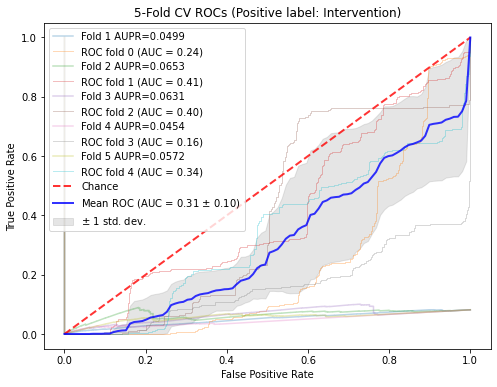

In [5]:
cv = StratifiedKFold(n_splits=5)
classifier = LogisticRegression(random_state=0)

y_real = []
y_proba = []
precision_array = []
recall_array = np.linspace(0, 1, 100)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(8, 6))
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])

    # plt.figure(1, figsize=(4, 3))
    # plt.clf()
    # plt.scatter(X[train].ravel(), y[train], color="black", zorder=20)
    # X_test = np.linspace(X.min(), X.max(), 300)

    # loss = expit(X_test * classifier.coef_ + classifier.intercept_).ravel()
    # plt.plot(X_test, loss, color="red", linewidth=3)

    # plt.ylabel("y")
    # plt.xlabel("X")
    # # plt.xticks(range(int(X.min()), int(X.max())))
    # # plt.yticks([0, 0.5, 1])
    # plt.ylim(-0.25, 1.25)
    # plt.xlim(int(X.min()), int(X.max()))
    # plt.legend(
    #     "Linear Regression Model",
    #     loc="lower right",
    #     fontsize="small",
    # )
    # plt.tight_layout()
    # plt.show()

    pred_proba = classifier.predict_proba(X[test])
    precision_fold, recall_fold, _ = precision_recall_curve(y[test], pred_proba[:, 1])
    precision_fold, recall_fold = precision_fold[::-1], recall_fold[::-1]  # reverse order of results
    prec_array = np.interp(recall_array, recall_fold, precision_fold)
    pr_auc = auc(recall_array, prec_array)
    precision_array.append(prec_array)

    lab_fold = 'Fold %d AUPR=%.4f' % (i+1, pr_auc)
    plt.plot(recall_fold, precision_fold, alpha=0.3, label=lab_fold)
    y_real.append(y[test])
    y_proba.append(pred_proba[:, 1])

    viz = RocCurveDisplay.from_estimator(
        classifier,
        X[test],
        y[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="5-Fold CV ROCs (Positive label: Intervention)",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate"
)
ax.legend(loc="upper left")
plt.show()


In [18]:
cv = StratifiedKFold(n_splits=5)
classifier = LogisticRegression(random_state=0)

y_real = []
y_proba = []
precision_array = []
recall_array = np.linspace(0, 1, 100)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])

    pred_proba = classifier.predict_proba(X[test])
    lab_fold = 'Fold %d AUPR=%.4f' % (i+1, pr_auc)
    y_real.append(y[test])
    y_proba.append(pred_proba[:, 1])


3757
3757


In [21]:
Y_proba = [item for sublist in y_proba for item in sublist]
Y_real = [item for sublist in y_real for item in sublist]

(array([5202., 5853., 3884., 1943., 1903.,    0.,    0.,    0.,    0.,
           0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

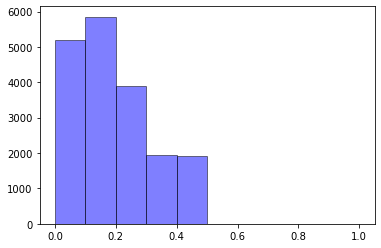

In [24]:
bin_ranges = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
plt.hist(Y_proba, bins=bin_ranges, color='blue', edgecolor='black', alpha=0.5)

(array([17253.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  1532.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

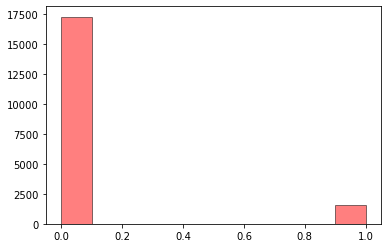

In [25]:
plt.hist(Y_real, bins=bin_ranges, color='red', edgecolor='black', alpha=0.5)

(array([780., 477., 147.,  63.,  65.,   0.,   0.,   0.,   0.,   0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

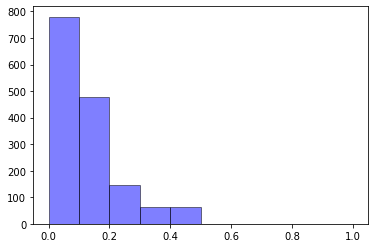

In [29]:
Y_proba = np.array(Y_proba)
Y_real = np.array(Y_real)

pos_mask = Y_real == 1
neg_mask = Y_real == 0

plt.hist(Y_proba[pos_mask], bins=bin_ranges, color='blue', edgecolor='black', alpha=0.5)

(array([4422., 5376., 3737., 1880., 1838.,    0.,    0.,    0.,    0.,
           0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

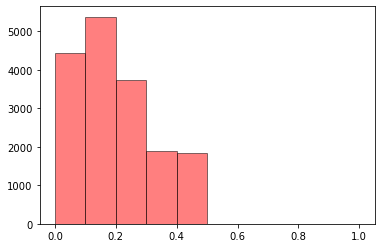

In [30]:
plt.hist(Y_proba[neg_mask], bins=bin_ranges, color='red', edgecolor='black', alpha=0.5)

C:\Users\Zalamaan\AppData\Local\Temp\ipykernel_101336\3123918772.py:21: RuntimeWarning: invalid value encountered in true_divide
  mcc_score = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
C:\Users\Zalamaan\AppData\Local\Temp\ipykernel_101336\3123918772.py:20: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = 2 * (prec * sens) / (prec + sens)
C:\Users\Zalamaan\AppData\Local\Temp\ipykernel_101336\3123918772.py:18: RuntimeWarning: invalid value encountered in longlong_scalars
  prec = tp / (tp + fp)
C:\Users\Zalamaan\AppData\Local\Temp\ipykernel_101336\3123918772.py:21: RuntimeWarning: invalid value encountered in true_divide
  mcc_score = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))


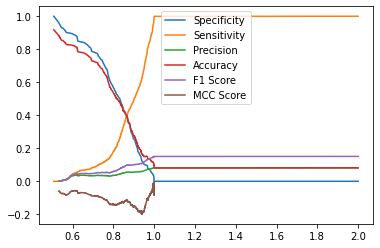

In [96]:
from sklearn.metrics import confusion_matrix
Y_proba_flipped = 1 - Y_proba
fpr, tpr, thresholds = roc_curve(Y_real, Y_proba_flipped)

# thresholds = np.linspace(0, 1, 1000)

specs = []
senss = []
precs = []
accs = []
f1_scores = []
mcc_scores = []
for t in thresholds:
    tn, fp, fn, tp = confusion_matrix(Y_real, Y_proba_flipped < t).ravel()

    spec = tn / (tn + fp)
    sens = tp / (tp + fn)
    prec = tp / (tp + fp)
    acc = (tp + tn) / (tp + tn + fp + fn)
    f1_score = 2 * (prec * sens) / (prec + sens)
    mcc_score = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    specs.append(spec)
    senss.append(sens)
    precs.append(prec)
    accs.append(acc)
    f1_scores.append(f1_score)
    mcc_scores.append(mcc_score)

plt.plot(thresholds, specs, label='Specificity')
plt.plot(thresholds, senss, label='Sensitivity')
plt.plot(thresholds, precs, label='Precision')
plt.plot(thresholds, accs, label='Accuracy')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.plot(thresholds, mcc_scores, label='MCC Score')
plt.legend()
plt.show()



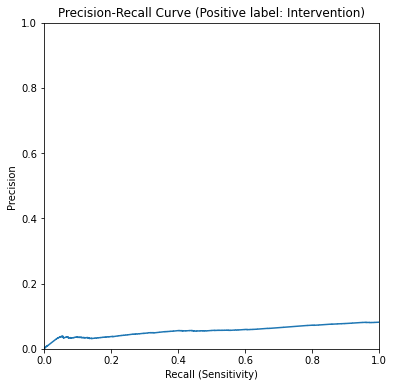

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plt.setp(ax, xlabel='Recall (Sensitivity)', ylabel='Precision', title='Precision-Recall Curve (Positive label: Intervention)', xlim=[0, 1], ylim=[0, 1])

ax.plot(senss, precs)

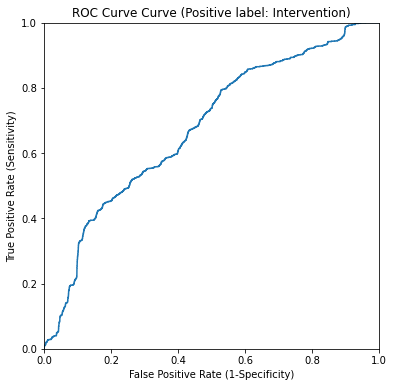

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plt.setp(ax, xlabel='False Positive Rate (1-Specificity)', ylabel='True Positive Rate (Sensitivity)', title='ROC Curve Curve (Positive label: Intervention)', xlim=[0, 1], ylim=[0, 1])

ax.plot(fpr, tpr)

C:\Users\Zalamaan\AppData\Local\Temp\ipykernel_101336\3916364778.py:16: RuntimeWarning: invalid value encountered in longlong_scalars
  prec = tp / (tp + fp)
C:\Users\Zalamaan\AppData\Local\Temp\ipykernel_101336\3916364778.py:19: RuntimeWarning: invalid value encountered in true_divide
  mcc_score = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))


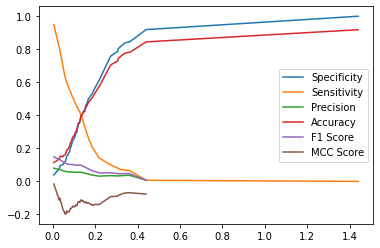

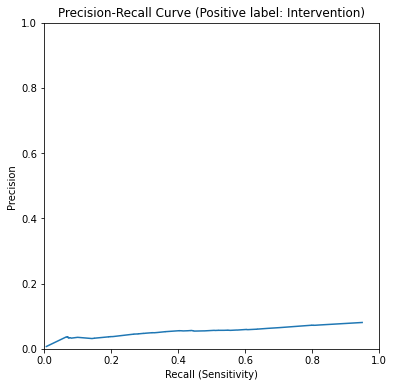

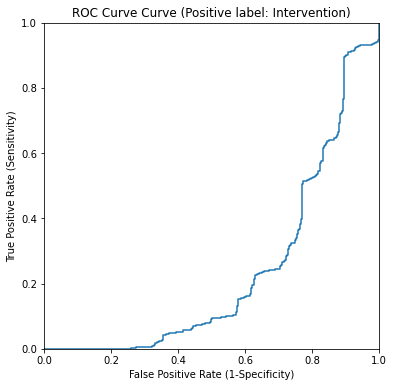

C:\Users\Zalamaan\AppData\Local\Temp\ipykernel_101336\3916364778.py:16: RuntimeWarning: invalid value encountered in longlong_scalars
  prec = tp / (tp + fp)
C:\Users\Zalamaan\AppData\Local\Temp\ipykernel_101336\3916364778.py:19: RuntimeWarning: invalid value encountered in true_divide
  mcc_score = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))


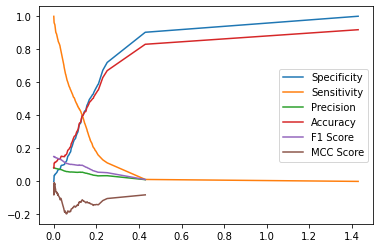

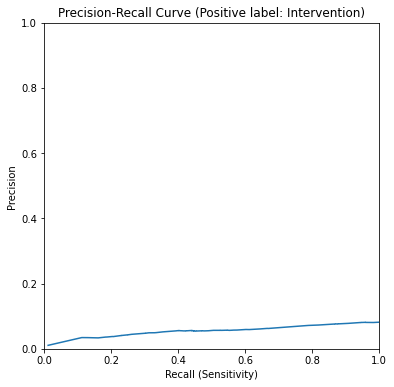

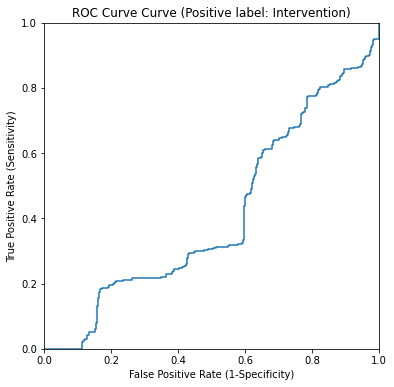

C:\Users\Zalamaan\AppData\Local\Temp\ipykernel_101336\3916364778.py:16: RuntimeWarning: invalid value encountered in longlong_scalars
  prec = tp / (tp + fp)
C:\Users\Zalamaan\AppData\Local\Temp\ipykernel_101336\3916364778.py:19: RuntimeWarning: invalid value encountered in true_divide
  mcc_score = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
C:\Users\Zalamaan\AppData\Local\Temp\ipykernel_101336\3916364778.py:16: RuntimeWarning: invalid value encountered in longlong_scalars
  prec = tp / (tp + fp)
C:\Users\Zalamaan\AppData\Local\Temp\ipykernel_101336\3916364778.py:19: RuntimeWarning: invalid value encountered in true_divide
  mcc_score = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
C:\Users\Zalamaan\AppData\Local\Temp\ipykernel_101336\3916364778.py:18: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = 2 * (prec * sens) / (prec + sens)
C:\Users\Zalamaan\AppData\Local\Temp\ipykernel_101336\3916364778.

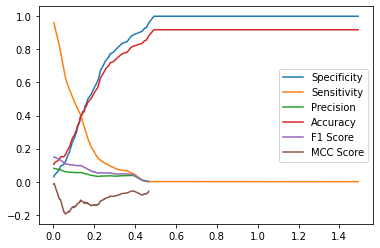

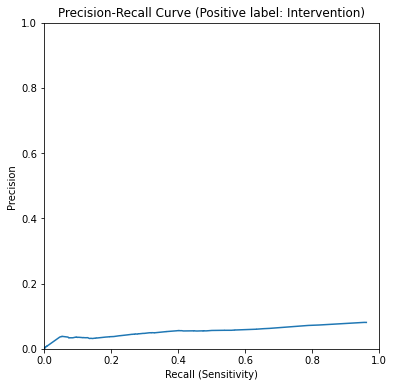

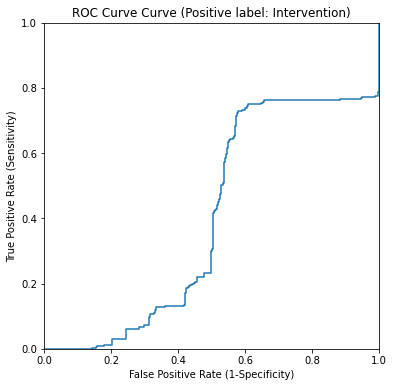

C:\Users\Zalamaan\AppData\Local\Temp\ipykernel_101336\3916364778.py:16: RuntimeWarning: invalid value encountered in longlong_scalars
  prec = tp / (tp + fp)
C:\Users\Zalamaan\AppData\Local\Temp\ipykernel_101336\3916364778.py:19: RuntimeWarning: invalid value encountered in true_divide
  mcc_score = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
C:\Users\Zalamaan\AppData\Local\Temp\ipykernel_101336\3916364778.py:18: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = 2 * (prec * sens) / (prec + sens)


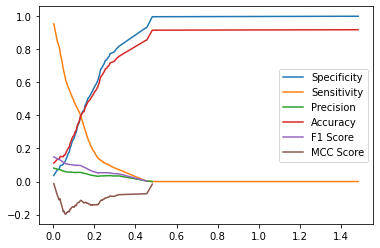

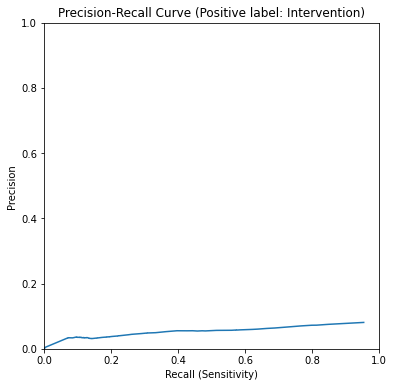

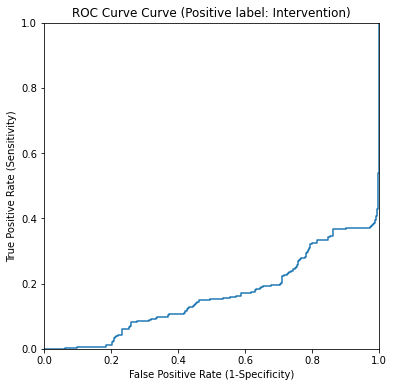

C:\Users\Zalamaan\AppData\Local\Temp\ipykernel_101336\3916364778.py:16: RuntimeWarning: invalid value encountered in longlong_scalars
  prec = tp / (tp + fp)
C:\Users\Zalamaan\AppData\Local\Temp\ipykernel_101336\3916364778.py:19: RuntimeWarning: invalid value encountered in true_divide
  mcc_score = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
C:\Users\Zalamaan\AppData\Local\Temp\ipykernel_101336\3916364778.py:18: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = 2 * (prec * sens) / (prec + sens)


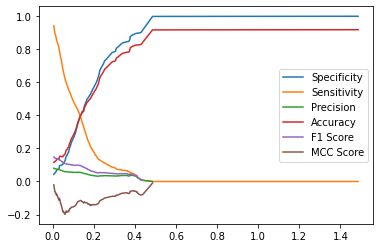

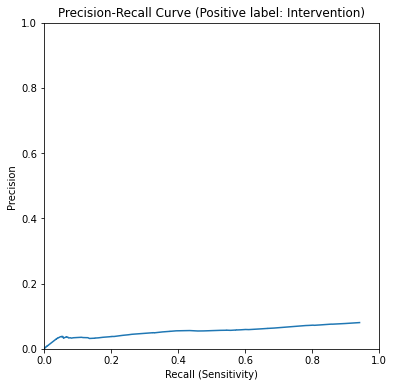

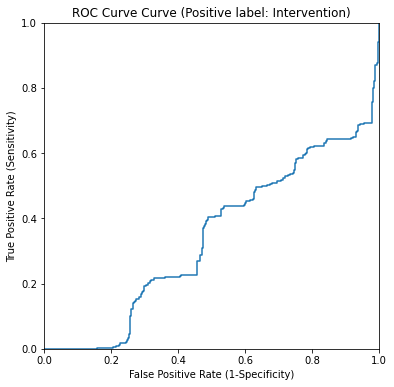

In [83]:
for i in range(5):

    fpr, tpr, thresholds = roc_curve(y_real[i], y_proba[i])

    specs = []
    senss = []
    precs = []
    accs = []
    f1_scores = []
    mcc_scores = []
    for t in thresholds:
        tn, fp, fn, tp = confusion_matrix(Y_real, Y_proba > t).ravel()

        spec = tn / (tn + fp)
        sens = tp / (tp + fn)
        prec = tp / (tp + fp)
        acc = (tp + tn) / (tp + tn + fp + fn)
        f1_score = 2 * (prec * sens) / (prec + sens)
        mcc_score = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

        specs.append(spec)
        senss.append(sens)
        precs.append(prec)
        accs.append(acc)
        f1_scores.append(f1_score)
        mcc_scores.append(mcc_score)

    plt.plot(thresholds, specs, label='Specificity')
    plt.plot(thresholds, senss, label='Sensitivity')
    plt.plot(thresholds, precs, label='Precision')
    plt.plot(thresholds, accs, label='Accuracy')
    plt.plot(thresholds, f1_scores, label='F1 Score')
    plt.plot(thresholds, mcc_scores, label='MCC Score')
    plt.legend()
    plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    plt.setp(ax, xlabel='Recall (Sensitivity)', ylabel='Precision', title='Precision-Recall Curve (Positive label: Intervention)', xlim=[0, 1], ylim=[0, 1])

    ax.plot(senss, precs)
    plt.show()

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    plt.setp(ax, xlabel='False Positive Rate (1-Specificity)', ylabel='True Positive Rate (Sensitivity)', title='ROC Curve Curve (Positive label: Intervention)', xlim=[0, 1], ylim=[0, 1])

    ax.plot(fpr, tpr)
    plt.show()

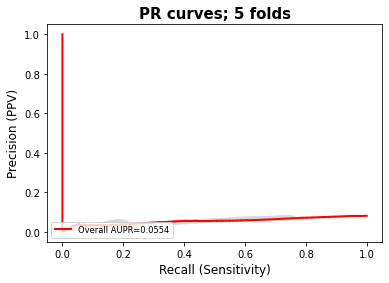

In [6]:
y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, _ = precision_recall_curve(y_real, y_proba)
lab = 'Overall AUPR=%.4f' % (auc(recall, precision))

plt.plot(recall, precision, lw=2, color='red', label=lab)

plt.legend(loc='lower left', fontsize='small')

mean_precision = np.mean(precision_array, axis=0)
std_precision = np.std(precision_array, axis=0)
plt.fill_between(recall_array, mean_precision + std_precision, mean_precision - std_precision, alpha=0.3, linewidth=0, color='grey')
plt.title("PR curves; {} folds".format(5), weight="bold", fontsize=15)
plt.xlabel("Recall (Sensitivity)", fontsize=12)
plt.ylabel("Precision (PPV)", fontsize=12)
plt.show()